## Task 2 : Class Activation Mapping (CAM) techniques

1. Upload Kaggle.json to access Dataset

In [ ]:
from google.colab import files
files.upload()

2. Downloading Dataset

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle

!kaggle datasets download -d jessicali9530/caltech256
!unzip -q caltech256.zip
!ls 256_ObjectCategories | head -n 10
!mv 256_ObjectCategories caltech256


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/caltech256
License(s): other
100% 2.12G/2.12G [00:17<00:00, 95.3MB/s]
100% 2.12G/2.12G [00:17<00:00, 129MB/s] 
001.ak47
002.american-flag
003.backpack
004.baseball-bat
005.baseball-glove
006.basketball-hoop
007.bat
008.bathtub
009.bear
010.beer-mug


3. Imports and System Specifications

In [3]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


4. Data transform

In [12]:
img_size   = 224
model_path = "/content/myvgg_model.pth"
data_dir   = "caltech256"

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

5. Load Dataset

In [5]:
dataset    = datasets.ImageFolder(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

6. Neural Network Class

In [6]:
class MyVGG(nn.Module):
    def __init__(self, num_classes=257):
        super(MyVGG, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            # Block 2
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            # Block 3
            nn.Conv2d(128,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            # Block 4
            nn.Conv2d(256,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            # Block 5
            nn.Conv2d(512,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512,512,3,padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.AdaptiveAvgPool2d((7,7))
        )
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7,4096), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(4096,1024), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(1024,num_classes)
        )
    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        return self.classifier(x)

7. Loading Model which I trained in Task 1

In [13]:
model = MyVGG(num_classes=257).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("Loaded model from", model_path)

Loaded model from /content/myvgg_model.pth


8. GradCAM hooks

In [14]:
activations = []
gradients   = []

def forward_hook(module, inp, out):
    activations.append(out)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

target_layer = model.features[42]
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

9. GradCAM function

In [15]:
def generate_gradcam(img_tensor, class_idx):
    activations.clear(); gradients.clear()
    output = model(img_tensor)
    model.zero_grad()
    one_hot = torch.zeros_like(output)
    one_hot[0, class_idx] = 1
    output.backward(gradient=one_hot)
    act = activations[0].cpu().detach().numpy()[0]
    grad = gradients[0].cpu().detach().numpy()[0]
    weights = np.mean(grad, axis=(1,2))
    cam = np.zeros(act.shape[1:], dtype=np.float32)
    for i,w in enumerate(weights):
        cam += w * act[i]
    cam = np.maximum(cam, 0)
    cam -= cam.min(); cam /= cam.max()
    return cv2.resize(cam, (img_size, img_size))

10. Visualization Function

In [16]:
def show_cam(img_tensor, cam, save_path=None):
    img = img_tensor.cpu().numpy()[0].transpose(1,2,0)
    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img = np.clip(img,0,1)
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB).astype(np.float32)/255
    overlay = 0.5*img + 0.5*heatmap
    overlay = np.clip(overlay,0,1)
    plt.figure(figsize=(5,5))
    plt.imshow(overlay); plt.axis('off')
    if save_path:
        plt.imsave(save_path, overlay)
    plt.show()

11. Examples

GT=152, Pred=152


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


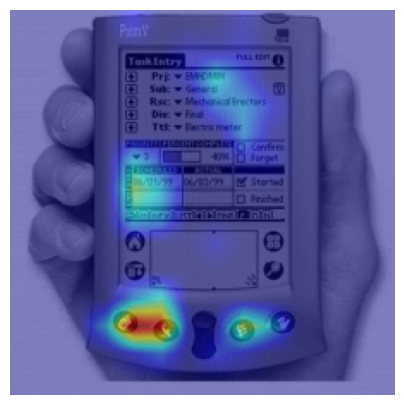

GT=128, Pred=128


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


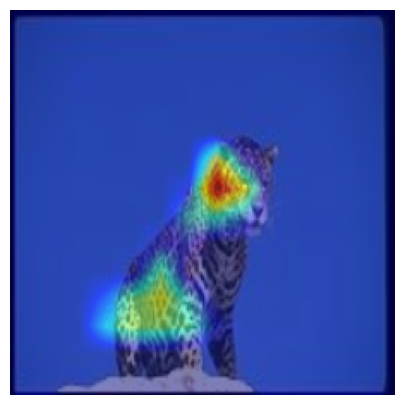

GT=139, Pred=139


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
<ipython-input-15-1ae3e62b90a3>:15: RuntimeWarning: invalid value encountered in divide
  cam -= cam.min(); cam /= cam.max()
<ipython-input-16-d6ae4794f510>:5: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)


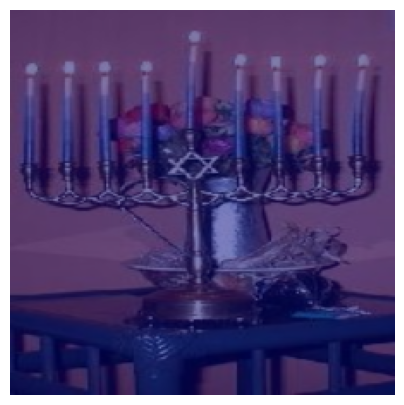

GT=239, Pred=239


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


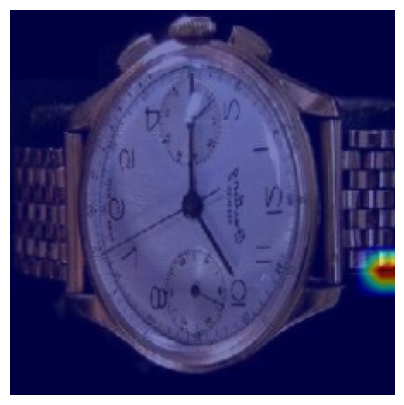

GT=30, Pred=127


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


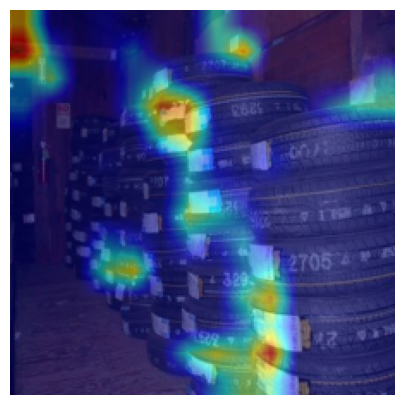

In [17]:
for idx, (img, lbl) in enumerate(dataloader):
    if idx >= 5: break
    img = img.to(device)
    with torch.no_grad():
        out   = model(img)
        predc = out.argmax(dim=1).item()
    print(f"GT={lbl.item()}, Pred={predc}")
    cam = generate_gradcam(img, predc)
    show_cam(img, cam, save_path=f"gradcam_{idx}.png")